In [0]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# load in preprocessed dataframe
aw = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/aw.parquet").cache()

# convert fl_date to int
datetonum = f.udf(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").timetuple().tm_yday)
aw = aw.withColumn("DAY_OF_YEAR", datetonum(f.col("FL_DATE")).cast(IntegerType())) \
.drop("FL_DATE")

aw.printSchema()

root
-- DEP_DEL15: float (nullable = true)
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- ORIGIN: string (nullable = true)
-- DEST: string (nullable = true)
-- CRS_DEP_DATETIME_UTC: timestamp (nullable = true)
-- ORIGIN_p: string (nullable = true)
-- DEP_DELAY_NEW_p: float (nullable = true)
-- CARRIER_DELAY_p: float (nullable = true)
-- WEATHER_DELAY_p: float (nullable = true)
-- NAS_DELAY_p: float (nullable = true)
-- SECURITY_DELAY_p: float (nullable = true)
-- LATE_AIRCRAFT_DELAY_p: float (nullable = true)
-- totNumFlights: long (nullable = true)
-- meanDelayAcrossFlights: double (nullable = true)
-- propDelayed: double (nullable = true)
-- DATE_day: date (nullable = true)
-- HOUR: integer (nullable = true)
-- avgTMP_airTemp: double (nullable = true)
-- avgWND_speed: double (nullable = true)
-- avgCIG_height: double (nullable = true)
-- avgVIS_distance: double (nullable = true)
-- avgSLP_airPressure: double (nullable = true)
-- avgPRECIP_duration: double (nullable = true)
-- avgPRECIP_amount: double (nullable = true)
-- avgSNOW_depth: double (nullable = true)
-- DAY_OF_YEAR: integer (nullable = true)

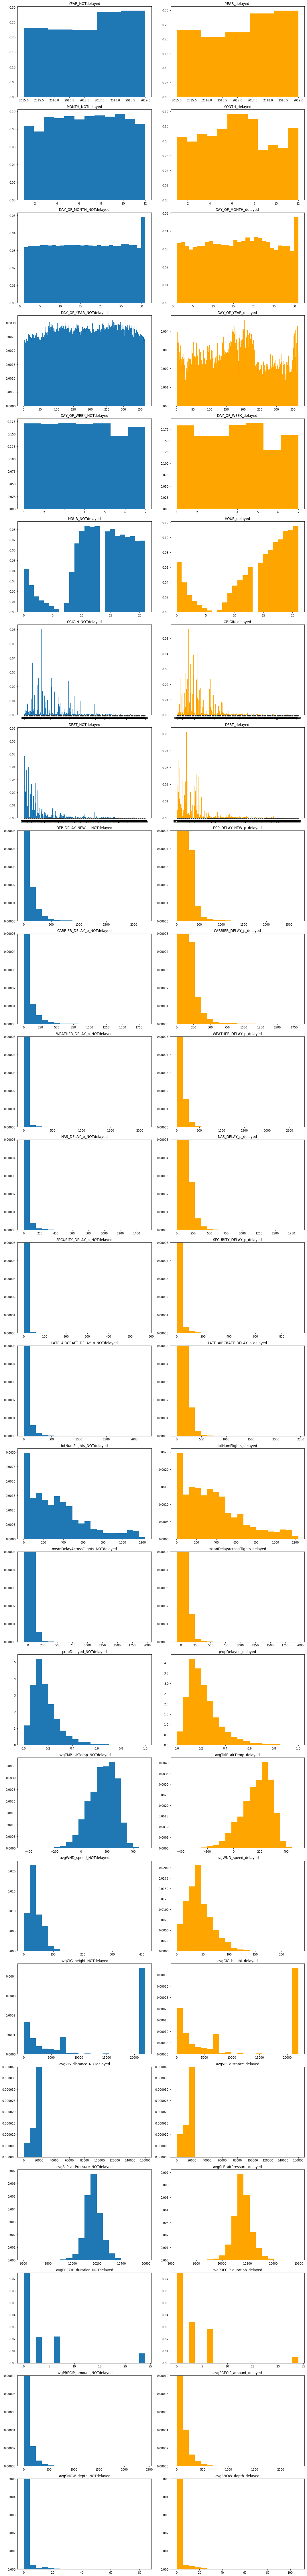

In [0]:
# plot distributions by class

defaultBins = 20
numBinsPerFeature = {'YEAR': 5, 'MONTH': 12, 'DAY_OF_MONTH': 30, 'DAY_OF_YEAR': 365, 'DAY_OF_WEEK': 7, 'HOUR': 24
                     , 'ORIGIN': defaultBins, 'DEST': defaultBins
                     , 'DEP_DELAY_NEW_p': defaultBins, 'CARRIER_DELAY_p': defaultBins, 'WEATHER_DELAY_p': defaultBins
                     , 'NAS_DELAY_p': defaultBins, 'SECURITY_DELAY_p': defaultBins, 'LATE_AIRCRAFT_DELAY_p': defaultBins 
                     , 'totNumFlights': defaultBins, 'meanDelayAcrossFlights': defaultBins, 'propDelayed': defaultBins
                     , 'avgTMP_airTemp': defaultBins, 'avgWND_speed': defaultBins, 'avgCIG_height': defaultBins, 'avgVIS_distance': defaultBins
                     , 'avgSLP_airPressure': defaultBins, 'avgPRECIP_duration': defaultBins, 'avgPRECIP_amount': defaultBins, 'avgSNOW_depth': defaultBins
                    }

notDelayedDf = aw.filter(f.col('DEP_DEL15')==0).cache()
delayedDf = aw.filter(f.col('DEP_DEL15')==1).cache()

nSubRows = len(numBinsPerFeature.keys())
nSubCols = 2
subplotCounter = 0

figH, axesH = plt.subplots(nSubRows, nSubCols, tight_layout=True, figsize=(15,5*nSubRows))

for featureName in numBinsPerFeature:
  numBins = numBinsPerFeature[featureName]
  
  (featureDataNotDelayed, featureDataDelayed) = (notDelayedDf.select(featureName).dropna().rdd.flatMap(lambda element: element).collect()
                                                 , delayedDf.select(featureName).dropna().rdd.flatMap(lambda element: element).collect()
                                                )
  
  # plot
  for classInd in np.arange(2):

    if classInd == 0:
      if featureName in ['ORIGIN', 'DEST']:
        numBins = notDelayedDf.select(featureName).dropna().distinct().count()
      
      axesH[subplotCounter, classInd].hist(featureDataNotDelayed, bins=numBins, density=True)
      axesH[subplotCounter, classInd].set_title(featureName+'_NOTdelayed')
    
    if classInd == 1:
      if featureName in ['ORIGIN', 'DEST']:
        numBins = delayedDf.select(featureName).dropna().distinct().count()
              
      axesH[subplotCounter, classInd].hist(featureDataDelayed, bins=numBins, density=True, color='orange')
      axesH[subplotCounter, classInd].set_title(featureName+'_delayed')
    
#     # don't show grid lines for features with many bins
#     if featureName not in ['ORIGIN', 'DEST', 'DAY_OF_YEAR']:
#       axesH[subplotCounter, classInd].xaxis.grid(True, which='major')
      
    # cut off y axis for distributions with large densities
    if featureName in ['DEP_DELAY_NEW_p', 'CARRIER_DELAY_p', 'WEATHER_DELAY_p', 'NAS_DELAY_p', 'SECURITY_DELAY_p', 'LATE_AIRCRAFT_DELAY_p', 'meanDelayAcrossFlights']:
      yLims = [0, 0.00005]
    elif featureName == 'avgVIS_distance':
      yLims = [0, 0.00004]
    elif featureName == 'avgPRECIP_duration':
      yLims = [0, 0.075]
    elif featureName == 'avgPRECIP_amount':
      yLims = [0, 0.0001]
    elif featureName == 'avgSNOW_depth':
      yLims = [0, 0.005]
    else:
      yLims = axesH[subplotCounter, classInd].get_ylim()
      
    axesH[subplotCounter, classInd].set_ylim(yLims)
  
  subplotCounter += 1
  